In [24]:
import numpy as np #numpy for math operation
import os
from utils import concatenate_scan_set, makeSparseDataFromRasterRepeat, computeVLIV, vlivCPUFitExp, load_nested_data_pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from time import time
from tqdm import tqdm
import cv2
from natsort import natsorted

data_path = "/Users/akapatil/Documents/OCT/timelapse/Timelapse_with_H2O2_12_20_2024/registered_cropped_bottom"
average_LivCurve = True
fitting_method = "CPU"
frameSeparationTime = 1 #1ms frame to frame time interval
alivInitial  = 20 #initla guess for aliv parameter curve fitting
swiftInitial = 10 # initial guess for swiftness parameter curve fitting
bounds = (0, np.inf)

In [25]:
image_list = os.listdir(data_path)#list all images address in data_path
fourD_image_volume_complete = load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array
# fourD_image = fourD_image_volume_complete[:, 40:50, 30:50, 200:254]
fourD_image = fourD_image_volume_complete[:20,:,10:-10,:100].astype(np.float64)

In [26]:
concatenate_set = concatenate_scan_set(fourD_image)

In [27]:
concatenate_set.dtype

dtype('float64')

In [28]:
blockRepeat = fourD_image.shape[0]
blockPerVolume = 1 #only 1 block is used in our protocal
bscanLocationPerBlock = fourD_image.shape[1] #the number of B-scan in one 3D volume

In [29]:
numLocation = bscanLocationPerBlock * blockPerVolume # Number of total B-scan

print('Processing: ' + data_path)

## OCT intensity
height = concatenate_set.shape[1]
width = concatenate_set.shape[2]

aliv = np.zeros((numLocation, height, width), dtype=np.float64)
swift = np.zeros((numLocation, height, width),  dtype=np.float64)

Processing: /Users/akapatil/Documents/OCT/timelapse/Timelapse_with_H2O2_12_20_2024/registered_cropped_bottom


In [30]:
for floc in tqdm(range(0,numLocation)):

    # fpg = bscanLocationPerBlock*blockRepeat # frames/group
    # theGrp = int(floc/bscanLocationPerBlock) # The group containing the location (loc)
    # fIdxInG = floc - theGrp*bscanLocationPerBlock # The frame index in the group

    # fStart = fpg * theGrp + fIdxInG # The start frame index in the volume of the location.
    # fStop = fStart + (fpg - fIdxInG) - 1
    # frameIndexes = range(int(fStart), int(fStop) + 1, int(bscanLocationPerBlock))
    # timePoints = np.linspace(0,blockRepeat-1, blockRepeat, dtype = int)*bscanLocationPerBlock

    # sparseSequence = np.array(concatenate_set[np.array(frameIndexes).astype(int) , :, :])

    # print(floc)
    sparseSequence, timePoints = makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)


    if floc == 0: #for save VLIV array
        VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width),  dtype=np.float64)

    
    ## Compute VLIV
    VLIV , possibleMtw , VoV = computeVLIV(sparseSequence, timePoints, maxTimeWidth =  np.nan, compute_VoV = False)
    
    ## Average LIV curve
    if average_LivCurve == True:
        twIdx = 0
        for twIdx in range(0, VLIV.shape[0]):                
            VLIV[twIdx,:,:] = cv2.blur(VLIV[twIdx,:,:], (3,3))
            twIdx = twIdx + 1

    ## curve fitting on LIV curve to compute saturation level (magnitude) and time constant (tau)
    # if fitting_method == 'GPU':
    #     mag, tau = vlivGpuFitExp(VLIV, possibleMtw, VoV, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint, use_weight)
    
    if fitting_method == 'CPU':
        mag, tau = vlivCPUFitExp(VLIV, possibleMtw, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint = False)

    aliv [floc] = mag ## aLIV
    swift [floc] = 1/ tau ## Swiftness
    VLIV_save[floc,:,:,:] = VLIV ## LIV curve (VLIV)
        

  0%|          | 0/500 [00:00<?, ?it/s]/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 500/500 [03:32<00:00,  2.35it/s]


In [31]:
# with open("swift_Yusuno.npy", "wb") as f:
#     np.save(f, swift)

# with open("aliv_Yusuno.npy", "wb") as f:
#     np.save(f, aliv)

# with open("VLIV_Yusuno.npy", "wb") as f:
#     np.save(f, VLIV_save)

In [34]:
np.unique(swift)

array([10.])

In [56]:
plt.imshow(np.max(fourD_image,axis=0))

KeyboardInterrupt: 

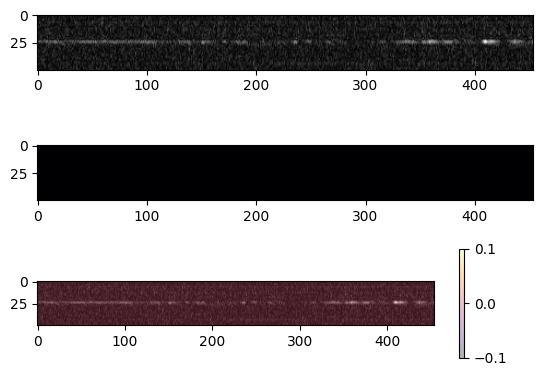

In [43]:
swift_normalized = cv2.normalize(swift[5, :, :,], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
fourD_normalized = cv2.normalize(fourD_image[10, 5, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 60), ncols=3)
# fo = ax1.imshow(fourD_normalized, cmap="gray")
# sw = ax2.imshow(swift_normalized, cmap="inferno")
# co_n = ax3.imshow(fourD_normalized, cmap="gray")
# co_s = ax3.imshow(swift_normalized, cmap="inferno", alpha = 0.4)
# fig.colorbar(co_s, ax=ax3)

plt.subplot(3, 1, 1)
plt.imshow(fourD_normalized, cmap="gray")
plt.subplot(3, 1, 2)
plt.imshow(swift_normalized, cmap="inferno")
plt.subplot(3, 1, 3)
plt.imshow(fourD_normalized, cmap="gray")
plt.imshow(swift_normalized, cmap="inferno", alpha=0.3)
plt.colorbar()

In [15]:
VLIV_save.shape

(500, 19, 50, 454)

Text(0, 0.5, 'AVG_LIV')

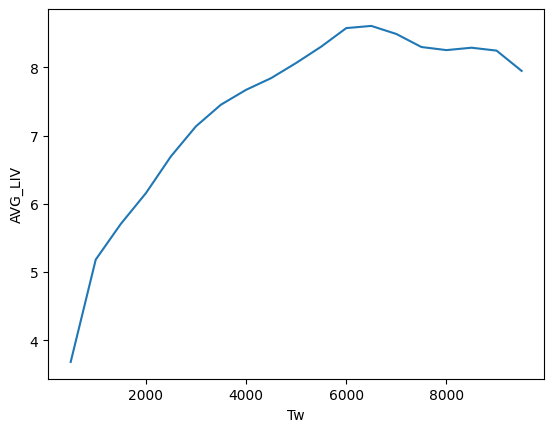

In [27]:
plt.plot(possibleMtw, VLIV_save[200, :, 24, 200])
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")

In [28]:
possibleMtw

array([ 500., 1000., 1500., 2000., 2500., 3000., 3500., 4000., 4500.,
       5000., 5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000.,
       9500.])